# Capstone Project

My research topic involves a meal delivery company operating in multiple cities.  There are many fulfillment centers in these cities to dispatch to their customers.  My task is to forecast the demand for meals in the centers in the coming weeks so the resources and raw material purchases can be executed accordingly.   

https://datahack.analyticsvidhya.com/contest/genpact-machine-learning-hackathon-1/#About

### Importing Libraries

In [121]:
import pandas as pd
import numpy as np
from sklearn import tree
import time

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
pd.set_option('display.max_columns', None) # show all the columns in the dataset
plt.style.use("fivethirtyeight") # styling your charts

# pre-processing
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

# modeling
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

# validation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, plot_confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_curve, RocCurveDisplay

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

print("All modules loaded")

All modules loaded


### Importing Data and Investigating Data

In [3]:
main=pd.read_csv(r"C:\Users\NemindaM19\Google Drive\AI and ML\Module 24\train.csv")
meal=pd.read_csv(r"C:\Users\NemindaM19\Google Drive\AI and ML\Module 24\meal_info.csv")
center=pd.read_csv(r"C:\Users\NemindaM19\Google Drive\AI and ML\Module 24\fulfilment_center_info.csv")
test=pd.read_csv(r"C:\Users\NemindaM19\Google Drive\AI and ML\Module 24\test_QoiMO9B.csv")

In [4]:
main.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [5]:
meal.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [6]:
center.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [7]:
main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 31.3 MB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32573 entries, 0 to 32572
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     32573 non-null  int64  
 1   week                   32573 non-null  int64  
 2   center_id              32573 non-null  int64  
 3   meal_id                32573 non-null  int64  
 4   checkout_price         32573 non-null  float64
 5   base_price             32573 non-null  float64
 6   emailer_for_promotion  32573 non-null  int64  
 7   homepage_featured      32573 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 2.0 MB


### Combining the train and test dataset together 

In [9]:
combined=pd.concat([main, test])

In [10]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 489121 entries, 0 to 32572
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     489121 non-null  int64  
 1   week                   489121 non-null  int64  
 2   center_id              489121 non-null  int64  
 3   meal_id                489121 non-null  int64  
 4   checkout_price         489121 non-null  float64
 5   base_price             489121 non-null  float64
 6   emailer_for_promotion  489121 non-null  int64  
 7   homepage_featured      489121 non-null  int64  
 8   num_orders             456548 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 37.3 MB


Test set is missing num_order columns.  Using Iterative imputer to fill the misssing num_orders

In [11]:
impute_it = IterativeImputer()
filled=impute_it.fit_transform(combined)

In [12]:
filled=pd.DataFrame(filled, columns=combined.columns)
filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489121 entries, 0 to 489120
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     489121 non-null  float64
 1   week                   489121 non-null  float64
 2   center_id              489121 non-null  float64
 3   meal_id                489121 non-null  float64
 4   checkout_price         489121 non-null  float64
 5   base_price             489121 non-null  float64
 6   emailer_for_promotion  489121 non-null  float64
 7   homepage_featured      489121 non-null  float64
 8   num_orders             489121 non-null  float64
dtypes: float64(9)
memory usage: 33.6 MB


Converting filled dataset to original Dtype

In [13]:
filled = filled.astype({'id':'int64','week':'int64','center_id':'int64','meal_id':'int64',
                        'emailer_for_promotion':'int64','homepage_featured':'int64','num_orders':'int64'})

In [14]:
filled

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40
...,...,...,...,...,...,...,...,...,...
489116,1250239,155,61,1543,482.09,484.09,0,0,110
489117,1039516,155,61,2304,483.09,483.09,0,0,114
489118,1158107,155,61,2664,322.07,323.07,0,0,228
489119,1444235,155,61,2569,322.07,323.07,0,0,228


Merging meal and center dataset to the filled dataset

In [15]:
filled=filled.merge(meal,how='left',on='meal_id')

In [16]:
df_p=filled.merge(center,how='left',on='center_id' )
# ID wasn't important to this analysis hence it was dropped
df_p=df_p.drop('id', axis=1) 
df_p

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0
1,1,55,1993,136.83,135.83,0,0,270,Beverages,Thai,647,56,TYPE_C,2.0
2,1,55,2539,134.86,135.86,0,0,189,Beverages,Thai,647,56,TYPE_C,2.0
3,1,55,2139,339.50,437.53,0,0,54,Beverages,Indian,647,56,TYPE_C,2.0
4,1,55,2631,243.50,242.50,0,0,40,Beverages,Indian,647,56,TYPE_C,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489116,155,61,1543,482.09,484.09,0,0,110,Desert,Indian,473,77,TYPE_A,4.5
489117,155,61,2304,483.09,483.09,0,0,114,Desert,Indian,473,77,TYPE_A,4.5
489118,155,61,2664,322.07,323.07,0,0,228,Salad,Italian,473,77,TYPE_A,4.5
489119,155,61,2569,322.07,323.07,0,0,228,Salad,Italian,473,77,TYPE_A,4.5


In [17]:
df_p.describe()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,op_area
count,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000
mean,79.810613,82.092206,2024.852268,332.879277,354.312259,0.080172,0.107346,260.394471,601.551172,56.621065,4.083865
std,44.343325,45.973390,547.408978,153.022073,160.352168,0.271560,0.309552,384.904966,66.182598,17.641296,1.092163
min,1.000000,10.000000,1062.000000,2.970000,55.350000,0.000000,0.000000,-318.000000,456.000000,23.000000,0.900000
25%,42.000000,43.000000,1558.000000,228.010000,243.500000,0.000000,0.000000,54.000000,553.000000,34.000000,3.600000
50%,81.000000,76.000000,1993.000000,299.760000,311.430000,0.000000,0.000000,149.000000,596.000000,56.000000,4.000000
75%,118.000000,110.000000,2539.000000,445.230000,458.810000,0.000000,0.000000,323.000000,651.000000,77.000000,4.500000
max,155.000000,186.000000,2956.000000,1113.620000,1112.620000,1.000000,1.000000,24299.000000,713.000000,93.000000,7.000000


In [18]:
# When truncation is required to test a small dataset 
# df=df_p.truncate(before=None, after=125000)
df=df_p

Basic Information of Completed Dataset

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 489121 entries, 0 to 489120
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   week                   489121 non-null  int64  
 1   center_id              489121 non-null  int64  
 2   meal_id                489121 non-null  int64  
 3   checkout_price         489121 non-null  float64
 4   base_price             489121 non-null  float64
 5   emailer_for_promotion  489121 non-null  int64  
 6   homepage_featured      489121 non-null  int64  
 7   num_orders             489121 non-null  int64  
 8   category               489121 non-null  object 
 9   cuisine                489121 non-null  object 
 10  city_code              489121 non-null  int64  
 11  region_code            489121 non-null  int64  
 12  center_type            489121 non-null  object 
 13  op_area                489121 non-null  float64
dtypes: float64(3), int64(8), object(3)
m

In [20]:
df.describe()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,op_area
count,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000
mean,79.810613,82.092206,2024.852268,332.879277,354.312259,0.080172,0.107346,260.394471,601.551172,56.621065,4.083865
std,44.343325,45.973390,547.408978,153.022073,160.352168,0.271560,0.309552,384.904966,66.182598,17.641296,1.092163
min,1.000000,10.000000,1062.000000,2.970000,55.350000,0.000000,0.000000,-318.000000,456.000000,23.000000,0.900000
25%,42.000000,43.000000,1558.000000,228.010000,243.500000,0.000000,0.000000,54.000000,553.000000,34.000000,3.600000
50%,81.000000,76.000000,1993.000000,299.760000,311.430000,0.000000,0.000000,149.000000,596.000000,56.000000,4.000000
75%,118.000000,110.000000,2539.000000,445.230000,458.810000,0.000000,0.000000,323.000000,651.000000,77.000000,4.500000
max,155.000000,186.000000,2956.000000,1113.620000,1112.620000,1.000000,1.000000,24299.000000,713.000000,93.000000,7.000000


In [21]:
df.describe(include=object)

,category,cuisine,center_type
count,489121,489121,489121
unique,14,4,3
top,Beverages,Italian,TYPE_A
freq,136781,131761,281597


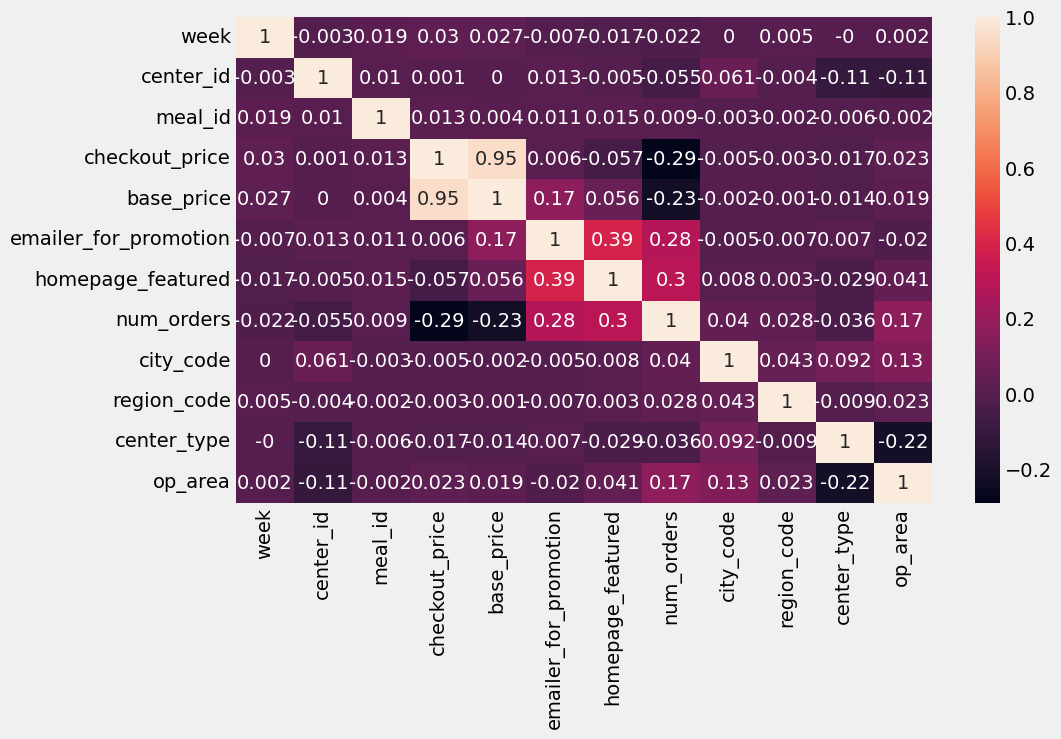

In [100]:
corr = df.corr().round(3)
plt.figure(figsize = (10, 6))
sns.heatmap(corr, annot = True);

## EDA

### Investigating numerical and catergorical features

In [101]:
for col in df.columns:
    print('-' * 40 + col + '-' * 40 , end=' - ')
    display(df[col].value_counts()) # value count for entire columns

----------------------------------------week---------------------------------------- - 

122    3359
105    3348
106    3347
140    3332
148    3332
       ... 
13     2838
12     2831
14     2830
7      2795
8      2786
Name: week, Length: 155, dtype: int64

----------------------------------------center_id---------------------------------------- - 

13     7555
10     7523
52     7499
43     7469
67     7414
       ... 
139    4948
57     4812
162    4676
41     4382
91     3712
Name: center_id, Length: 77, dtype: int64

----------------------------------------meal_id---------------------------------------- - 

2290    11908
1727    11906
1062    11903
1109    11903
1754    11902
2707    11887
1962    11884
1993    11883
1778    11883
1971    11870
1885    11861
2581    11841
2826    11827
2322    11754
1558    11719
1207    11564
1230    11490
2640    11482
1878    11236
2539    11212
2631    11175
1543    10996
2760    10921
2664    10623
1248    10599
2704    10535
1216    10404
2304    10391
2126    10331
1445    10329
2569    10229
1525    10027
2492    10020
2490    10016
2444     9665
2139     9570
2577     9207
2306     8886
2867     8619
1247     7600
1902     7183
1770     7168
1571     5055
1311     5024
1803     5015
1438     4712
1198     4515
2494     4511
1847     4417
2956     3745
2104     2718
Name: meal_id, dtype: int64

----------------------------------------checkout_price---------------------------------------- - 

290.03    7702
291.03    7594
292.03    7530
486.03    6859
484.03    6839
          ... 
56.26        1
700.34       1
574.30       1
76.69        1
683.91       1
Name: checkout_price, Length: 1995, dtype: int64

----------------------------------------base_price---------------------------------------- - 

292.03    9788
291.03    9680
290.03    9663
280.33    6860
446.23    6701
          ... 
711.04       1
711.98       1
564.54       1
711.01       1
659.60       1
Name: base_price, Length: 1931, dtype: int64

----------------------------------------emailer_for_promotion---------------------------------------- - 

0    449907
1     39214
Name: emailer_for_promotion, dtype: int64

----------------------------------------homepage_featured---------------------------------------- - 

0    436616
1     52505
Name: homepage_featured, dtype: int64

----------------------------------------num_orders---------------------------------------- - 

13       12416
15       12317
14       12286
28       11570
27       11488
         ...  
3645         1
6655         1
7062         1
10544        1
453          1
Name: num_orders, Length: 2027, dtype: int64

----------------------------------------category---------------------------------------- - 

Beverages       136781
Rice Bowl        35717
Sandwich         35599
Pizza            35444
Starters         31925
Other Snacks     31483
Desert           31407
Salad            30868
Pasta            29621
Seafood          28613
Biryani          21951
Extras           14554
Soup             13640
Fish             11518
Name: category, dtype: int64

----------------------------------------cuisine---------------------------------------- - 

Italian        131761
Thai           126558
Indian         120419
Continental    110383
Name: cuisine, dtype: int64

----------------------------------------city_code---------------------------------------- - 

590    58708
526    46589
638    21483
522    14430
517    14039
604    13989
699    12958
647    12667
576    12276
614    12228
676    11973
593    11556
685     7499
700     7395
713     7335
579     7330
679     7274
456     7198
703     7177
698     6883
577     6844
596     6761
599     6734
648     6526
602     6501
659     6489
654     6472
628     6412
651     6406
562     6367
615     6318
556     6302
561     6273
473     6273
461     6175
620     6137
485     6135
609     6133
675     6125
658     5982
553     5931
649     5910
680     5739
695     5675
683     5672
632     5655
702     5634
515     5433
478     5360
693     4948
541     4812
Name: city_code, dtype: int64

----------------------------------------region_code---------------------------------------- - 

56    204911
34    124978
77    101300
85     32521
23      6883
71      6761
93      6133
35      5634
Name: region_code, dtype: int64

----------------------------------------center_type---------------------------------------- - 

1    281597
3    106602
2    100922
Name: center_type, dtype: int64

----------------------------------------op_area---------------------------------------- - 

4.0    56295
3.9    51968
3.8    42933
4.4    27915
4.5    27528
2.8    27273
4.1    25024
7.0    22187
4.8    19980
3.4    18465
3.6    18077
5.1    14315
4.2    13516
2.7    13316
3.0    11973
2.0    10184
6.7     7555
6.3     7523
5.6     7499
3.7     7274
3.5     7143
3.2     6775
5.0     6602
5.3     6489
4.6     6412
4.7     6406
2.4     5360
2.9     5040
1.9     4382
0.9     3712
Name: op_area, dtype: int64

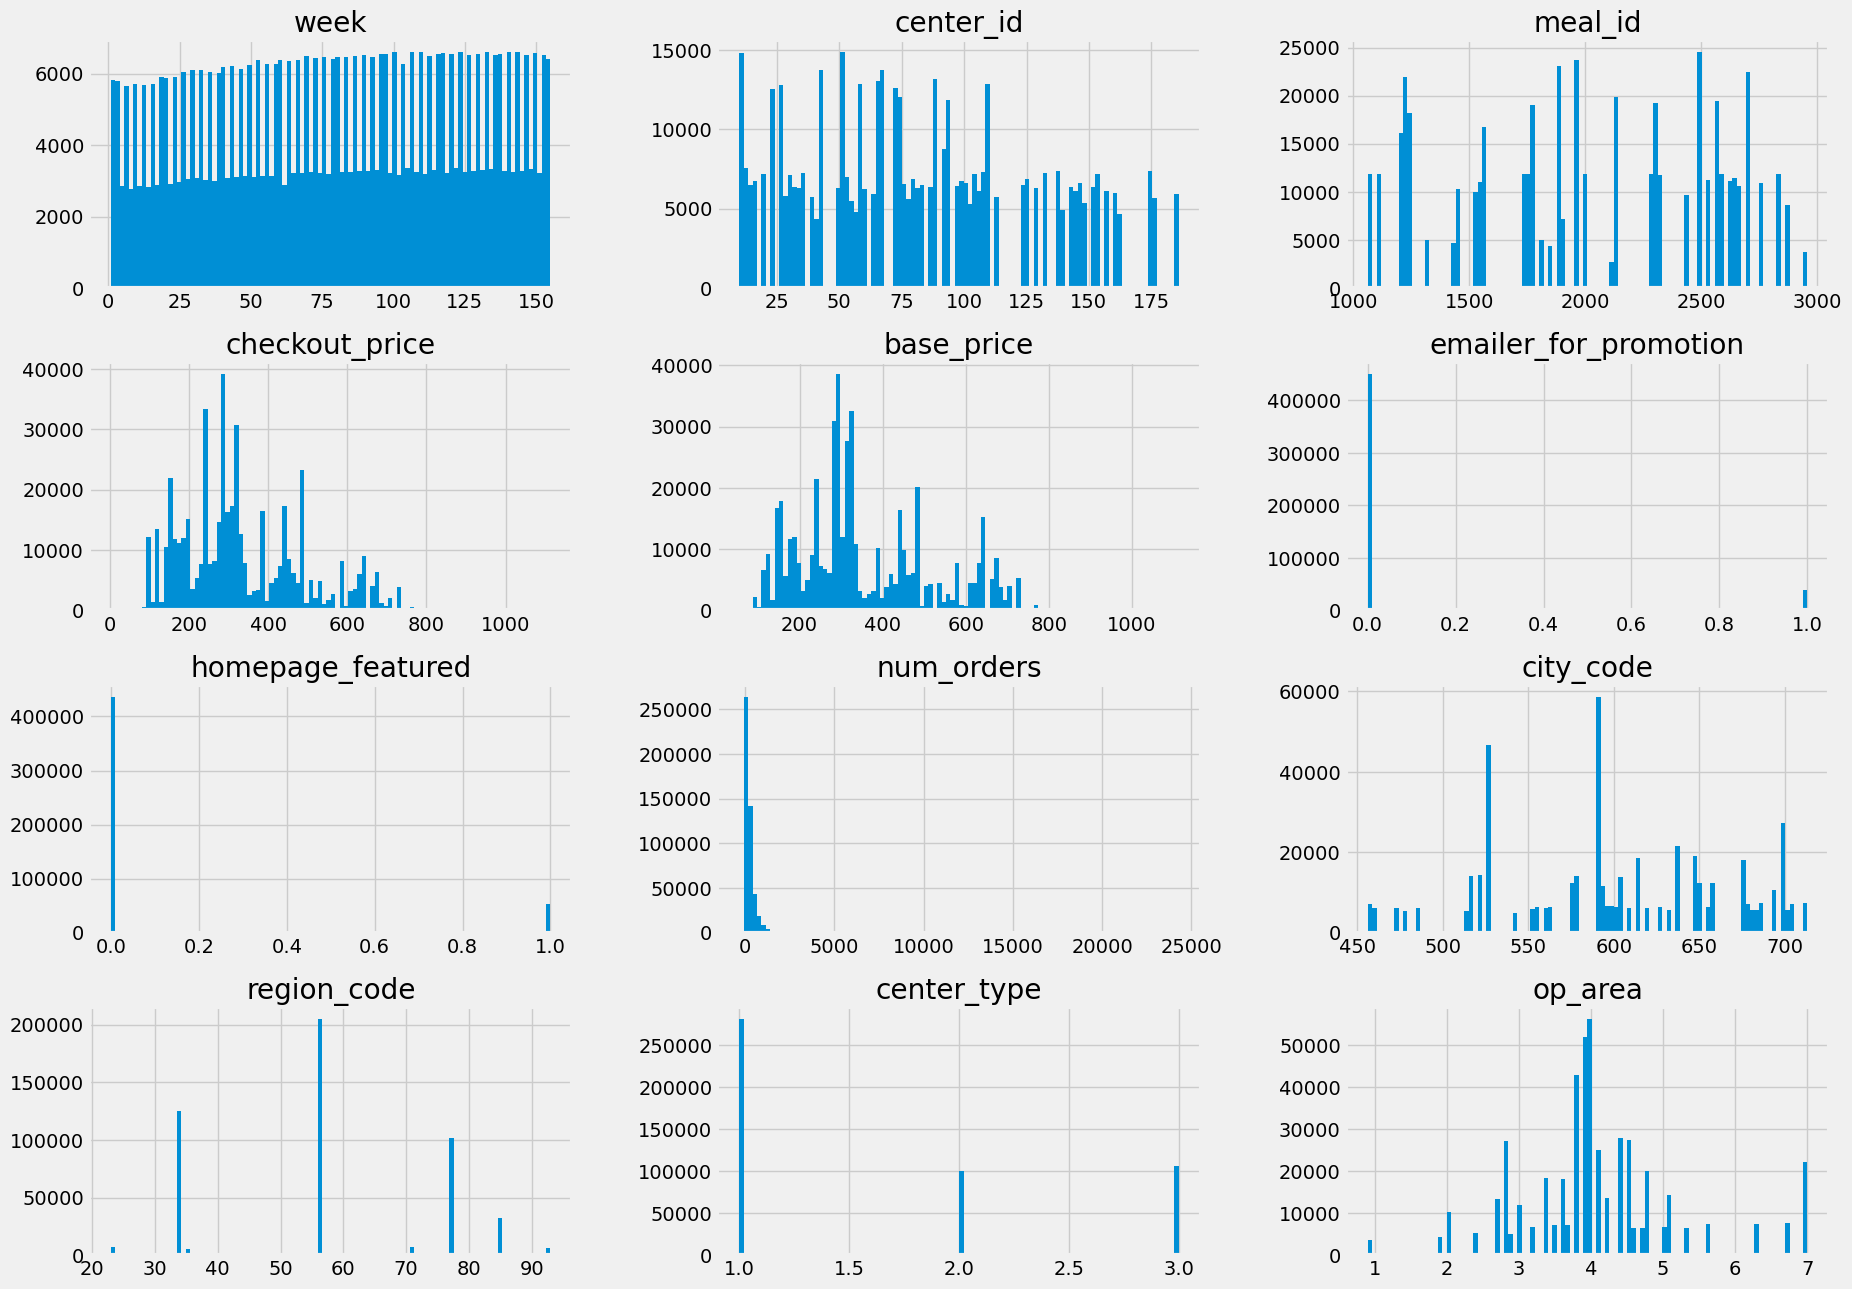

In [102]:
num_fea = df.select_dtypes(include=['int64', 'float64']).columns.values
df[num_fea].hist(bins=100, figsize=(20,15))
plt.show()

In [25]:
cat_feat = df.select_dtypes(include=['object']).columns.values

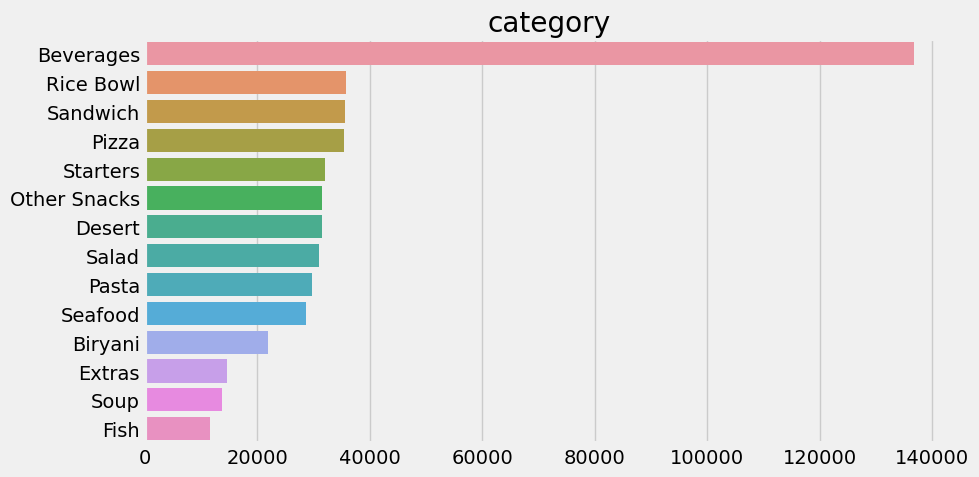

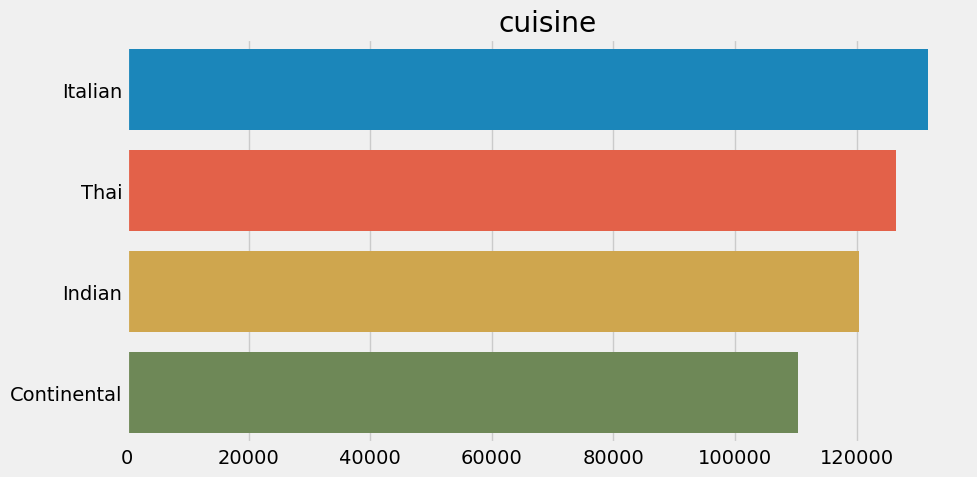

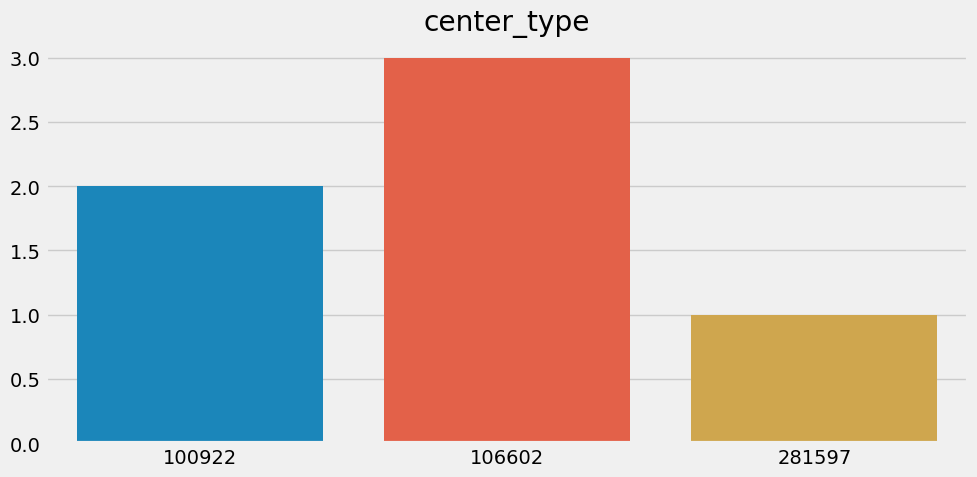

In [103]:
for col in cat_feat:
    plt.figure(figsize=(10,5))    
    sns.barplot(data=df, x=df[col].value_counts().values, y=df[col].value_counts().index)    
    plt.title(col)    
    plt.tight_layout()

### Further Investigation of Data 

* Patterns of base price and checkout price
* Is there a pattern to the number of orders vs week 
* Which meal id, catergoty, and cusine has the most activities
* Which center id, city code, region code, center type has the most activities
* Which meal id within the each center id has the most activities
* Relationship between center id and city code 

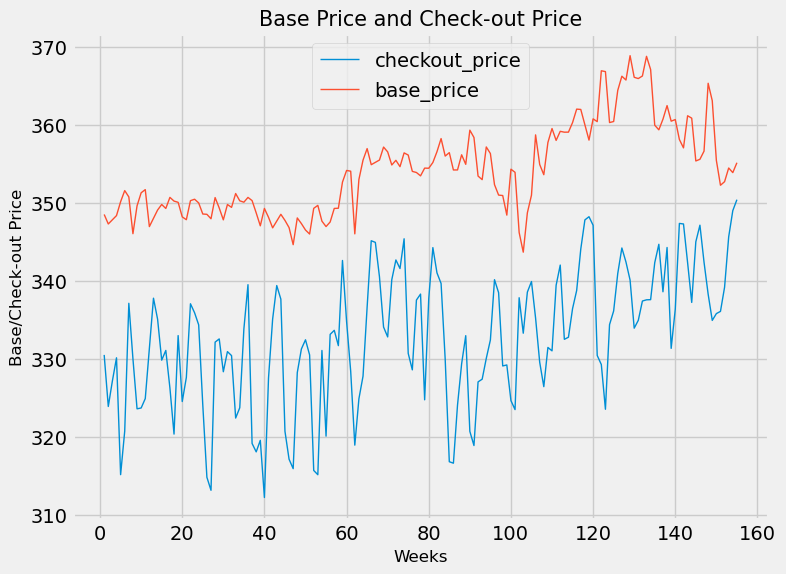

In [27]:
plt.figure(figsize=(8,6))
sns.lineplot(data=df, x='week',y='checkout_price', linewidth = 1.0, ci=None, label="checkout_price");
sns.lineplot(data=df, x='week',y='base_price', linewidth = 1.0, ci=None,label="base_price");
plt.title('Base Price and Check-out Price',fontdict={'fontsize':15})
plt.ylabel('Base/Check-out Price',fontdict={'fontsize':12})
plt.xlabel('Weeks',fontdict={'fontsize':12})
plt.legend(loc='upper center');

From the figure above, base price is higher than the checkout price, which tells us that meal delivery company is not making profits.  It maybe that this is a non for profit company.  

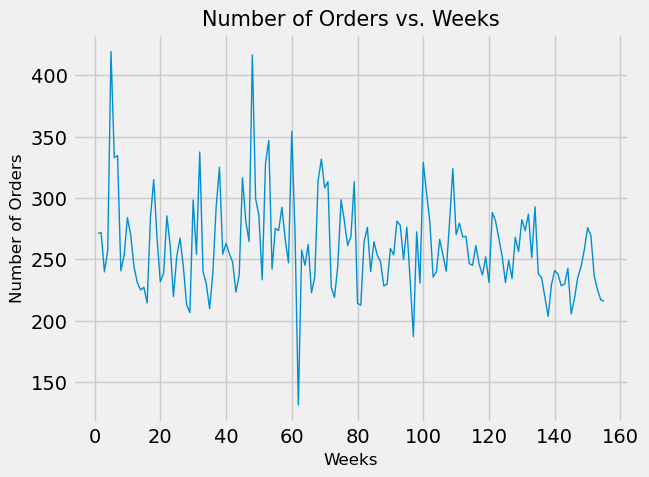

In [28]:
sns.lineplot(data=df, x='week', y='num_orders', linewidth = 1.0, ci=None);
plt.title('Number of Orders vs. Weeks',fontdict={'fontsize':15})
plt.ylabel('Number of Orders',fontdict={'fontsize':12})
plt.xlabel('Weeks',fontdict={'fontsize':12});

From the figure above we can determine that there is no established trend and trend neither increases nor decreases.

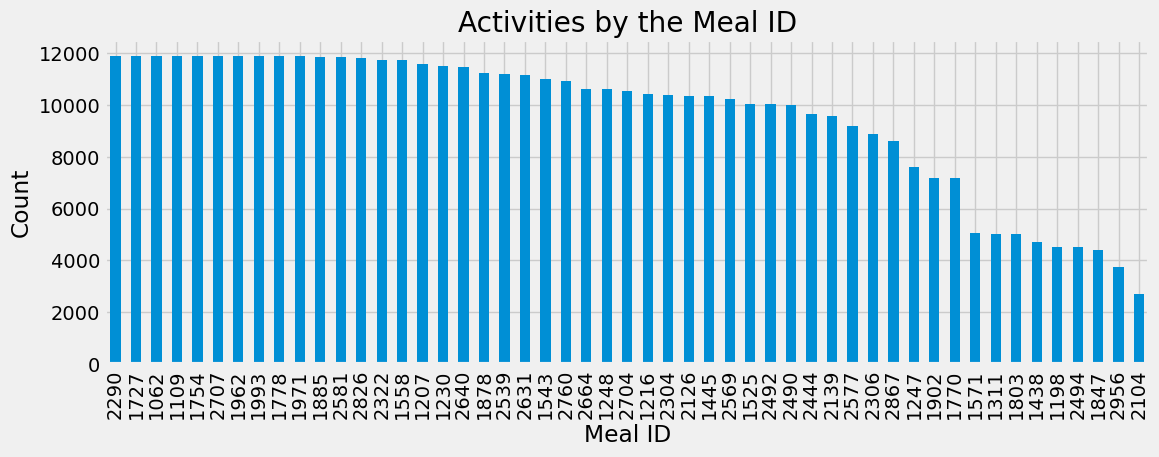

In [29]:
df.meal_id.value_counts().plot(kind = 'bar', figsize=(12, 4), title='Activities by the Meal ID');
plt.xlabel('Meal ID');
plt.ylabel('Count');

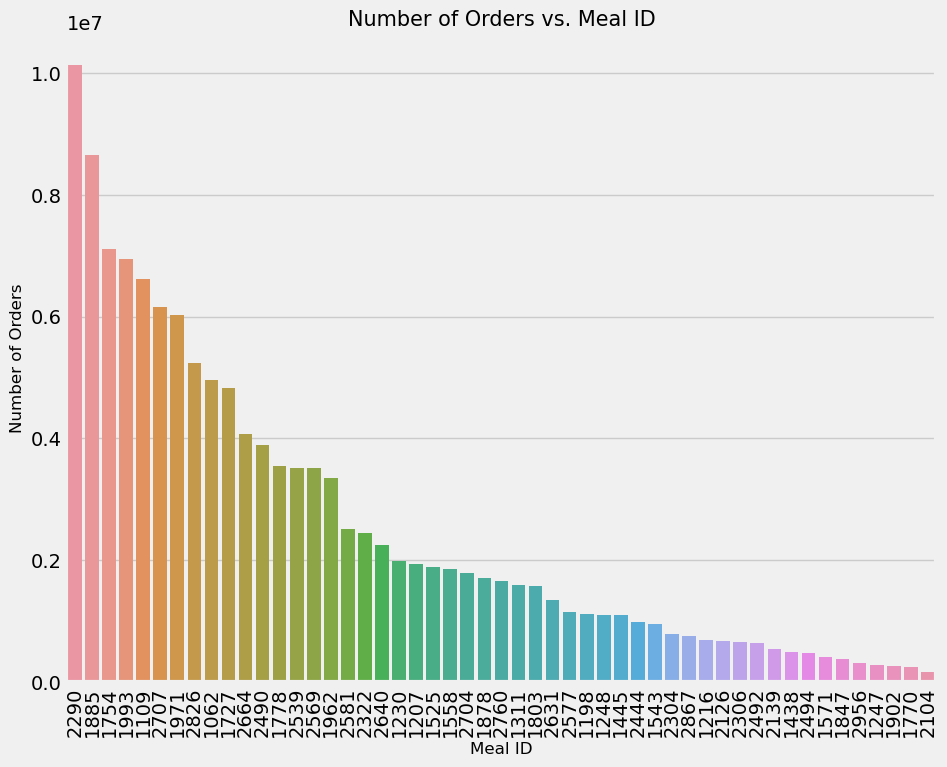

In [30]:
plt.figure(figsize=(10,8))
df_m_ID = df.groupby('meal_id').num_orders.agg(sum)
df_m_ID = df_m_ID.reset_index()

sns.barplot(data=df_m_ID, x='meal_id', y='num_orders',
            order=df_m_ID.sort_values('num_orders',ascending=False).meal_id);
plt.title('Number of Orders vs. Meal ID',fontdict={'fontsize':15})
plt.ylabel('Number of Orders',fontdict={'fontsize':12})
plt.xlabel('Meal ID',fontdict={'fontsize':12});
plt.xticks(rotation=90);

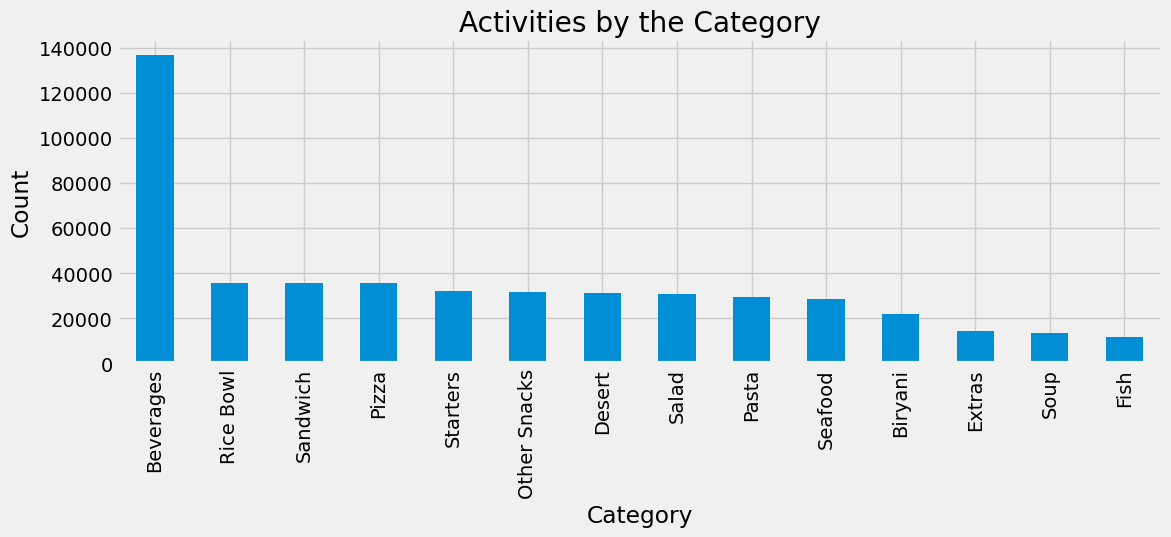

In [31]:
df.category.value_counts().plot(kind = 'bar', figsize=(12, 4), title='Activities by the Category');
plt.xlabel('Category');
plt.ylabel('Count');

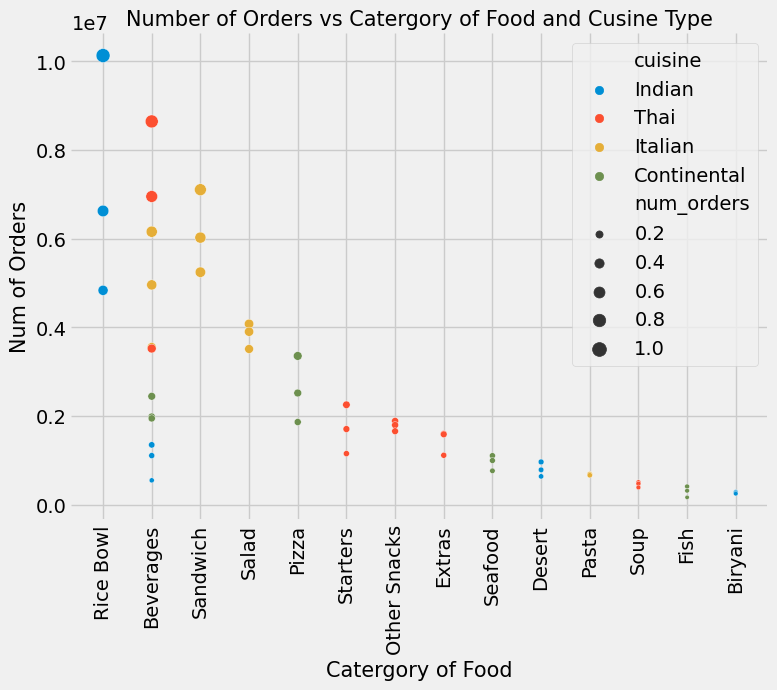

In [32]:
plt.figure(figsize=(8,6))
df4=df.groupby(['meal_id','cuisine','category'])\
.agg({'num_orders':'sum'}).sort_values('num_orders',ascending=False).reset_index()
sns.scatterplot(data=df4, x="category", y='num_orders', hue='cuisine',
                size='num_orders',sizes=(10, 100), legend="auto")
plt.title('Number of Orders vs Catergory of Food and Cusine Type',fontdict={'fontsize':15})
plt.ylabel('Num of Orders',fontdict={'fontsize':15})
plt.xlabel('Catergory of Food',fontdict={'fontsize':15})
plt.xticks(rotation=90)
plt.legend(loc='upper right')
sns.despine(bottom = True, left = True);

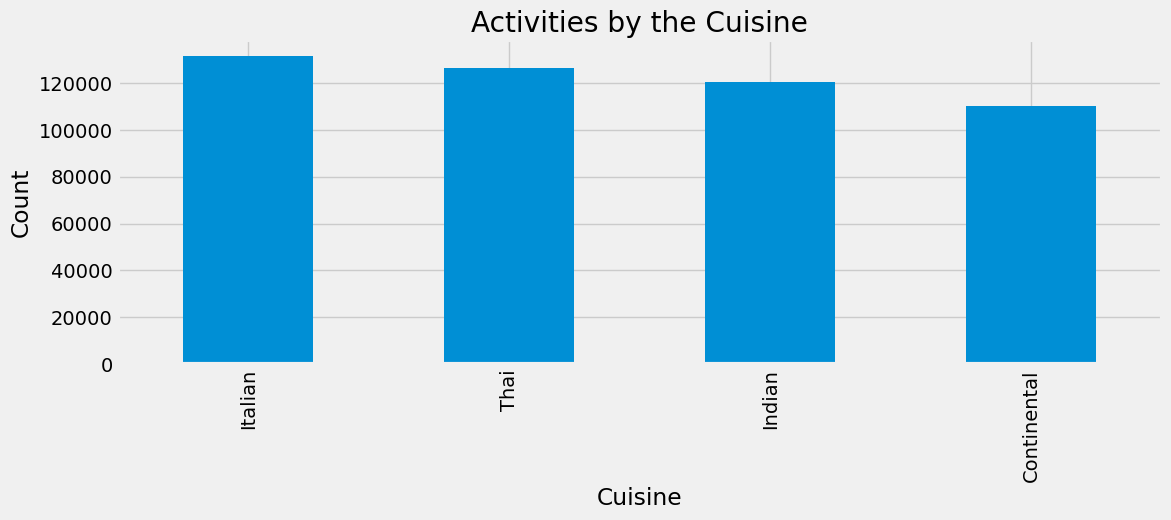

In [33]:
df.cuisine.value_counts().plot(kind = 'bar', figsize=(12, 4), title='Activities by the Cuisine');
plt.xlabel('Cuisine');
plt.ylabel('Count');

In [34]:
meal_id_select =[2290,1885,1993]
df.query('meal_id==@meal_id_select').value_counts(['category','cuisine'])

category   cuisine
Beverages  Thai       23744
Rice Bowl  Indian     11908
dtype: int64

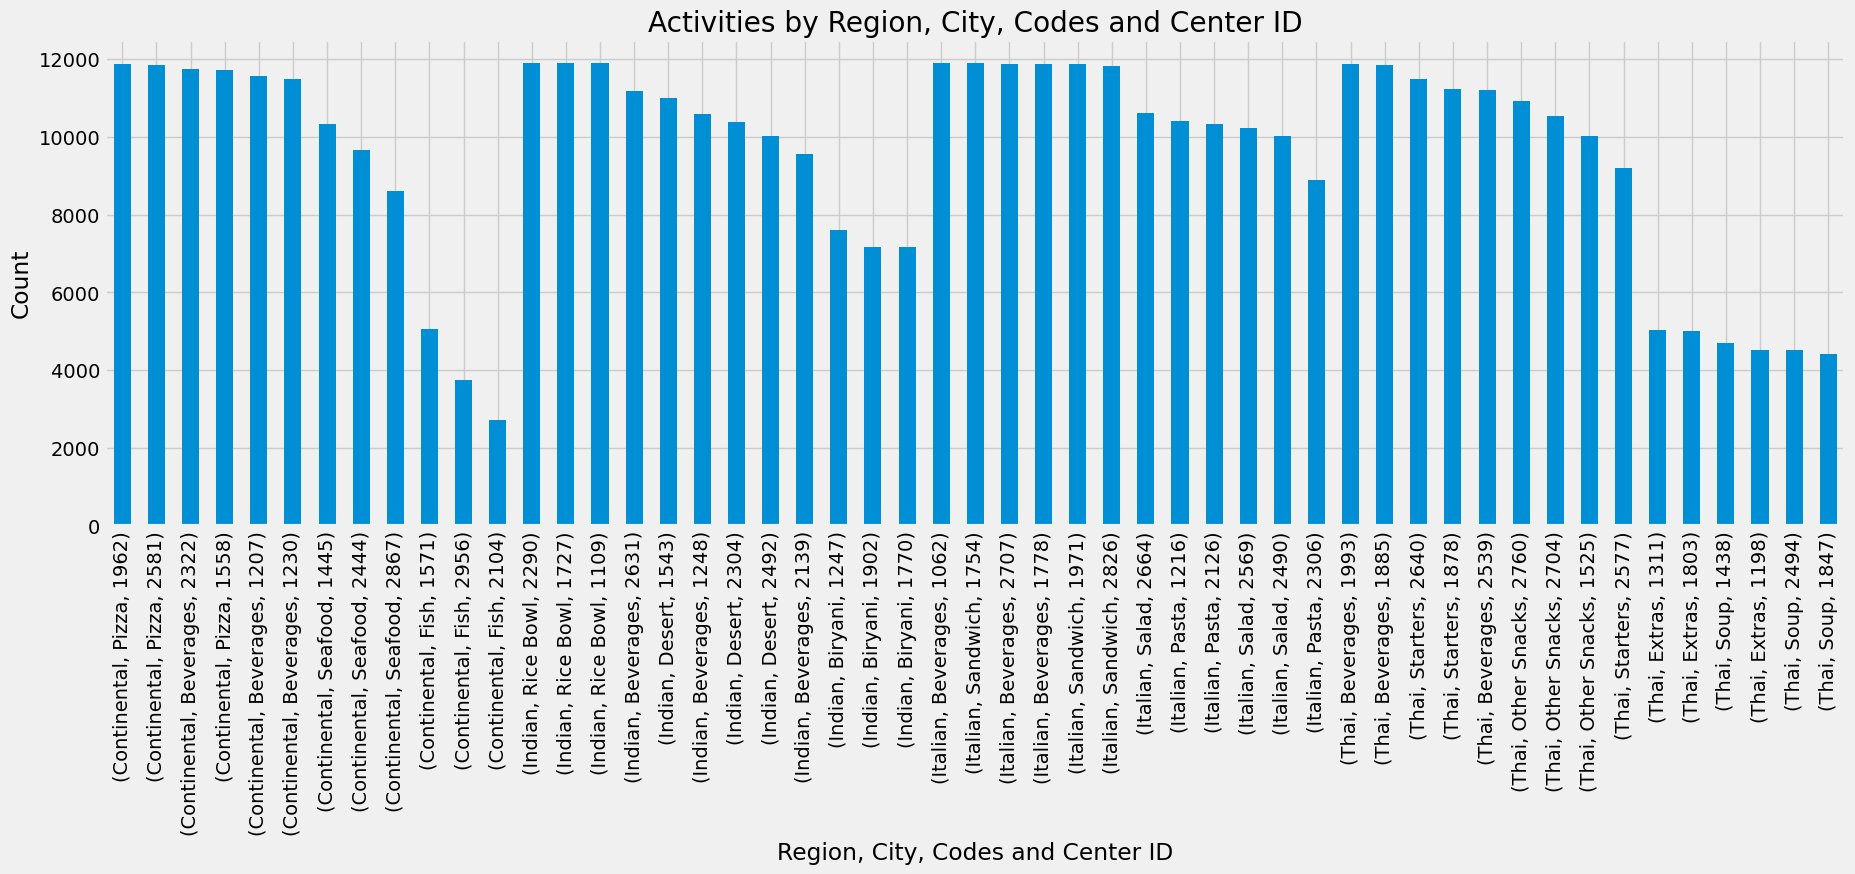

In [35]:
df_meal=df[['category','cuisine','meal_id']]
df_meal.groupby(['cuisine']).value_counts(['category','meal_id'])\
.plot(kind='bar',figsize=(20, 6), title='Activities by Region, City, Codes and Center ID');
plt.xlabel('Region, City, Codes and Center ID');
plt.ylabel('Count');

In [36]:
meal_id_select =[1962,2290,1062,1993]
df.query('meal_id==@meal_id_select').value_counts(['category','cuisine'])

category   cuisine    
Rice Bowl  Indian         11908
Beverages  Italian        11903
Pizza      Continental    11884
Beverages  Thai           11883
dtype: int64

From the figures above we can conclude that certain catergories in cuisines have equal amount of demand, but overall beverages from all the cuisines has the highest demand. 

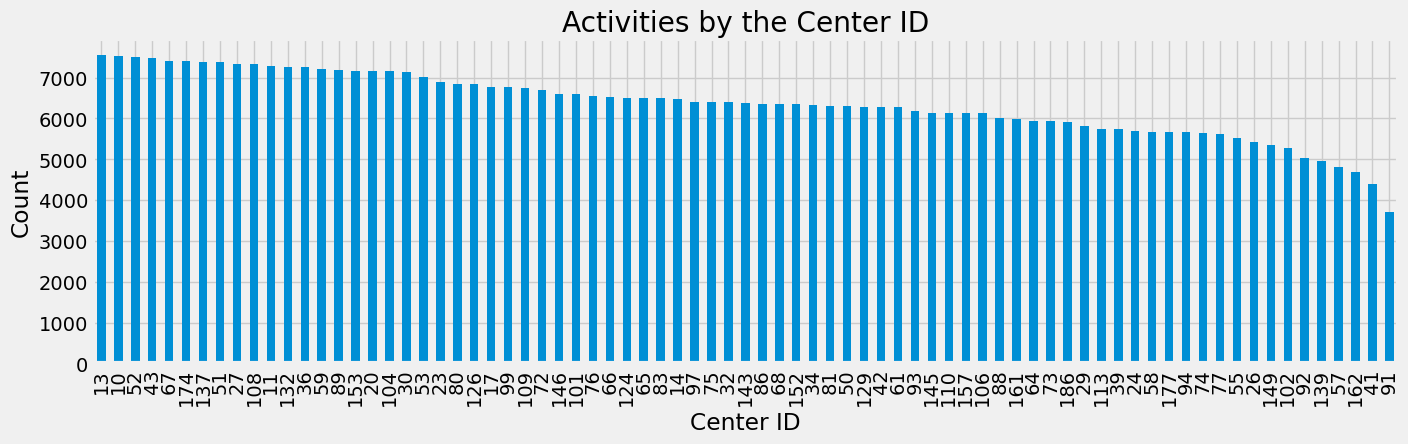

In [37]:
df.center_id.value_counts().plot(kind = 'bar', figsize=(15, 4), title='Activities by the Center ID');
plt.xlabel('Center ID');
plt.ylabel('Count');

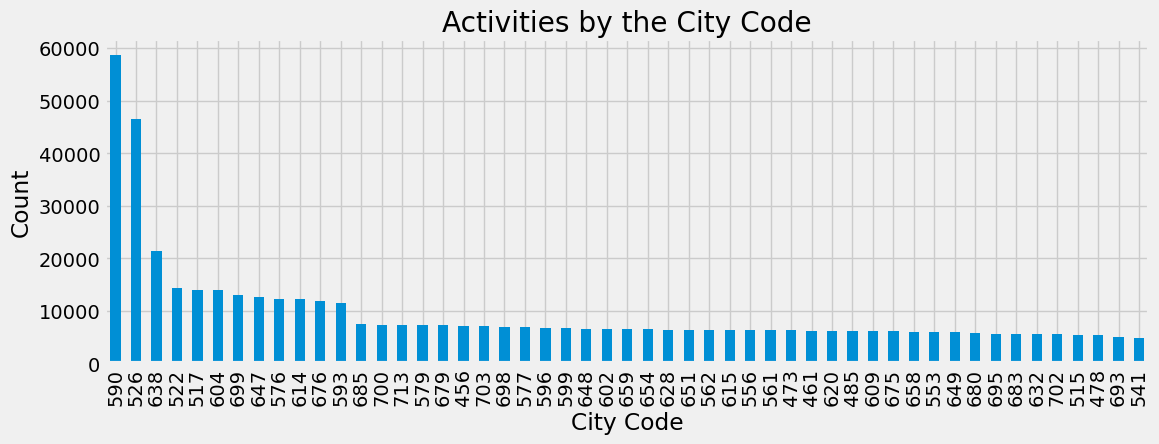

In [38]:
df.city_code.value_counts().plot(kind = 'bar', figsize=(12, 4), title='Activities by the City Code');
plt.xlabel('City Code');
plt.ylabel('Count');

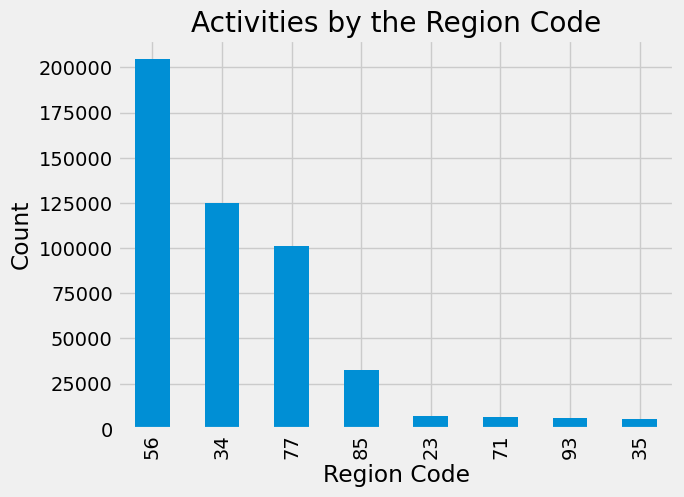

In [39]:
df.region_code.value_counts().plot(kind = 'bar', title='Activities by the Region Code');
plt.xlabel('Region Code');
plt.ylabel('Count');

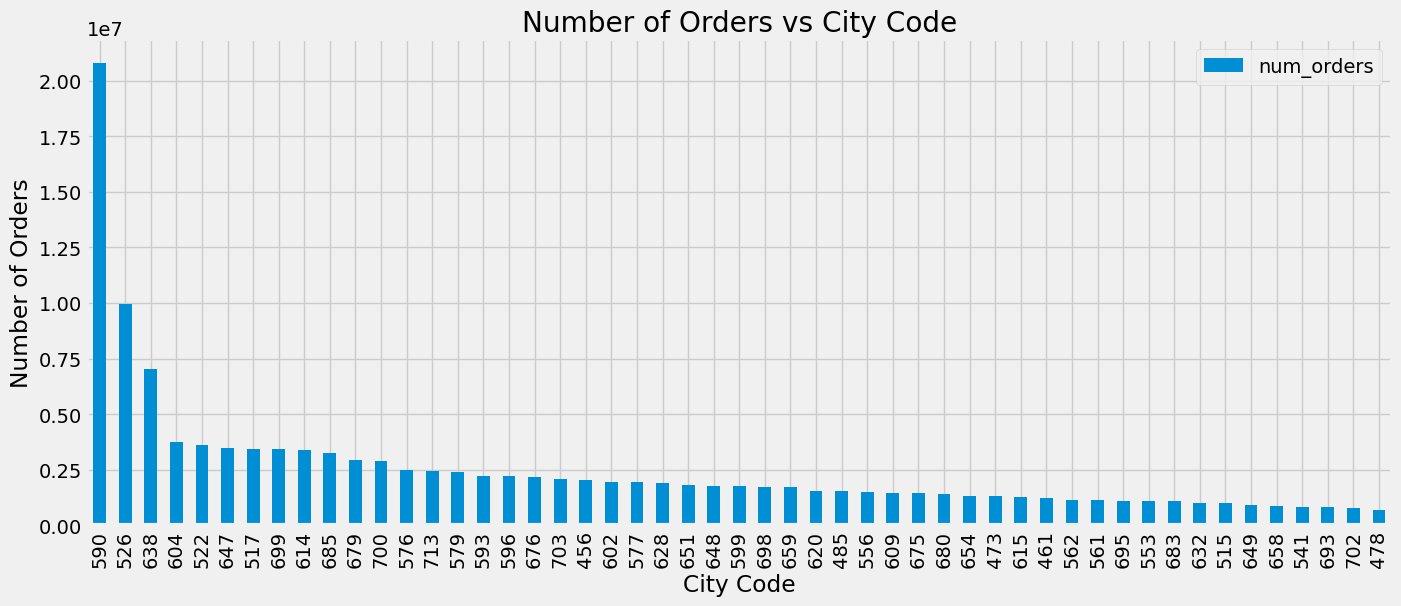

In [40]:
df.groupby(['city_code'],as_index=False).sum('num_orders').sort_values('num_orders',ascending=False)\
.plot(kind='bar', x='city_code', y='num_orders', title='Number of Orders vs City Code', figsize=(15,6))
plt.xlabel('City Code');
plt.ylabel('Number of Orders');

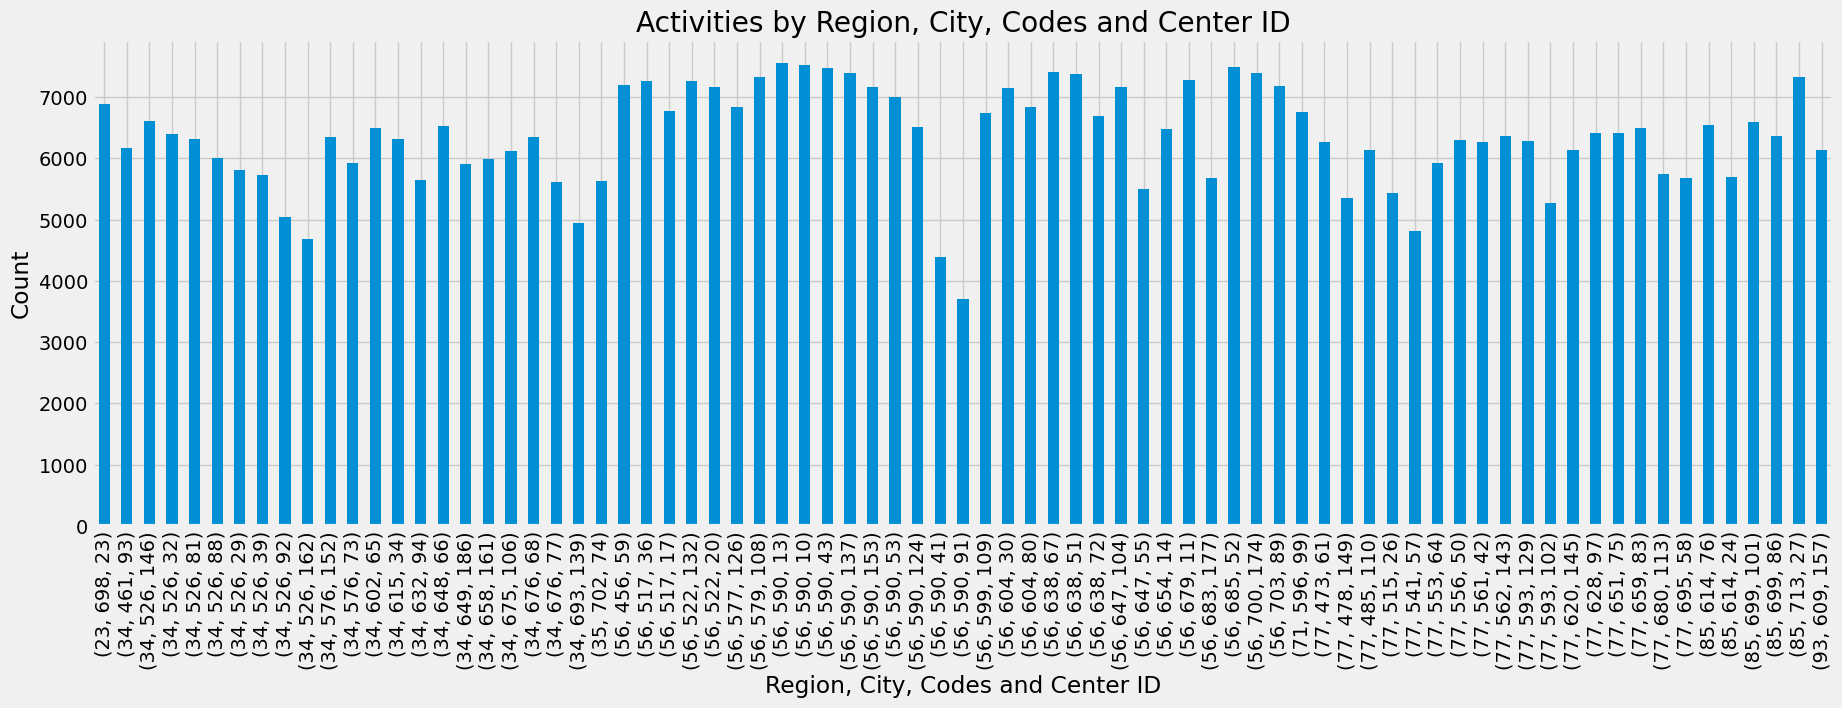

In [41]:
df_center=df[['region_code','city_code','center_id']]
df_center.groupby(['region_code','city_code']).value_counts('center_id')\
.plot(kind='bar',figsize=(20, 6), title='Activities by Region, City, Codes and Center ID');
plt.xlabel('Region, City, Codes and Center ID');
plt.ylabel('Count');

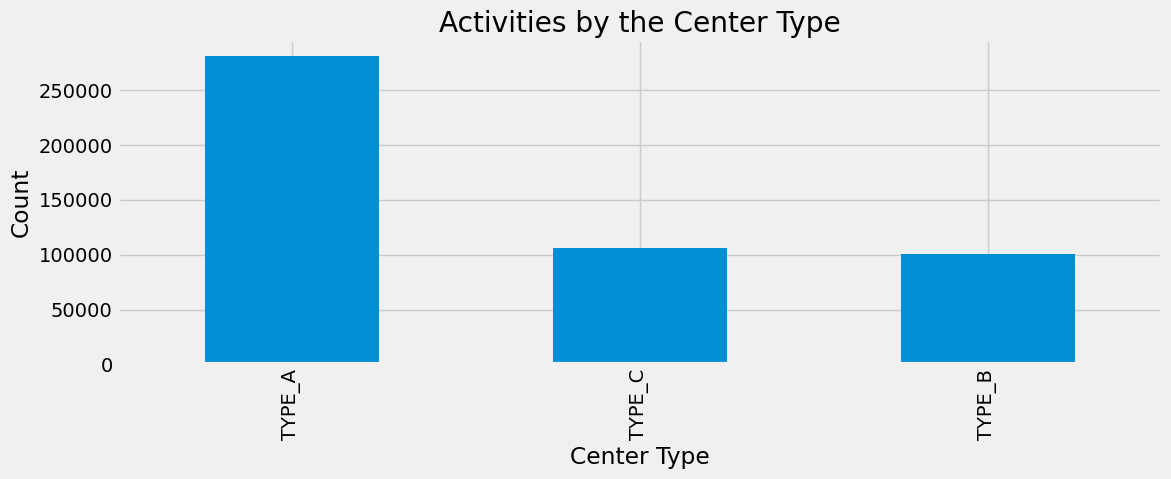

In [42]:
df.center_type.value_counts().plot(kind = 'bar', figsize=(12, 4), title='Activities by the Center Type');
plt.xlabel('Center Type');
plt.ylabel('Count');

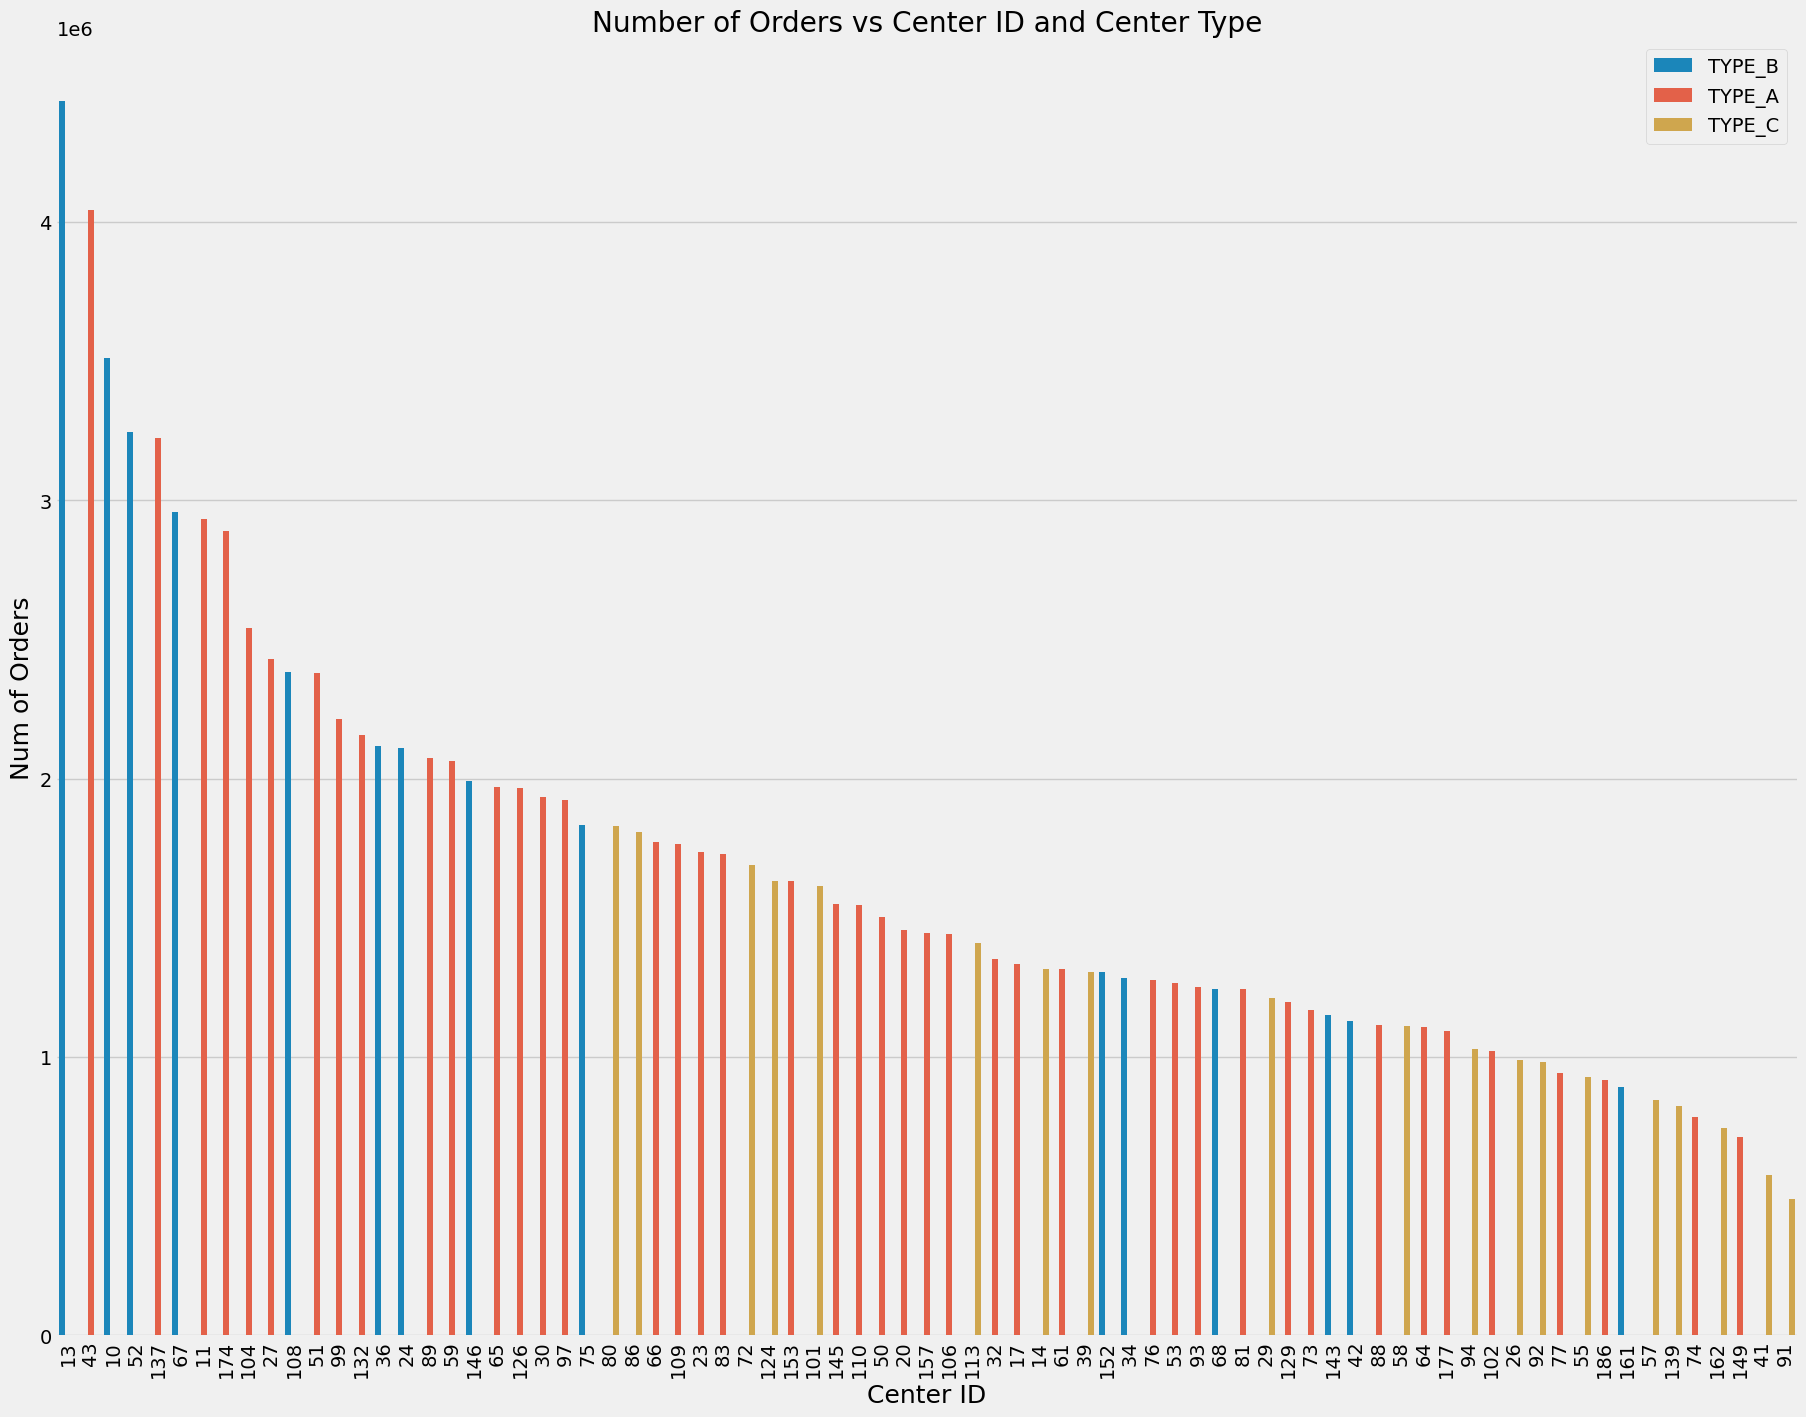

In [43]:
plt.figure(figsize=(20,16))
df3 = df.groupby(['center_id', 'center_type']).num_orders.agg(sum)
df3 = df3.reset_index()
sns.barplot(data=df3, x='center_id', y='num_orders',hue='center_type',
            order=df3.sort_values('num_orders',ascending=False).center_id)
plt.title('Number of Orders vs Center ID and Center Type')
plt.ylabel('Num of Orders',fontdict={'fontsize':18})
plt.xlabel('Center ID',fontdict={'fontsize':18})
plt.xticks(rotation=90)
plt.legend(loc='upper right')
sns.despine(bottom = True, left = True);

From the figures above we can conclude that region 56 with city code 590 has the highest count, and region 34 with city code 526 has the second highest count, and finally, region 56 with city code 638 has the third highest count.  Also it can be observed that center id 13 in center Type B has the highest number of orders.    

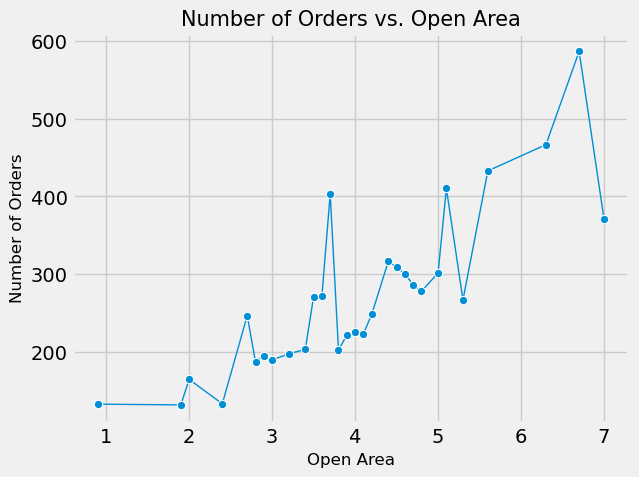

In [44]:
sns.lineplot(data=df, x='op_area', y='num_orders',linewidth = 1.0, ci=None, marker='o')
plt.title('Number of Orders vs. Open Area',fontdict={'fontsize':15})
plt.ylabel('Number of Orders',fontdict={'fontsize':12})
plt.xlabel('Open Area',fontdict={'fontsize':12});

Also, it can be observed that number of orders goes up as the open area increases.  However, open area at 7 has a very drastic drop in orders.  

1 = Sent 
0 = Not sent


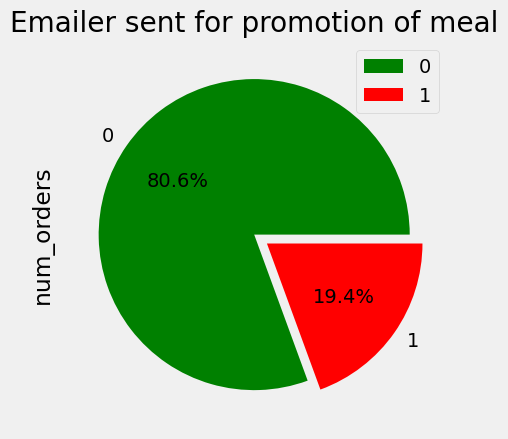

In [45]:
df.groupby('emailer_for_promotion').num_orders.agg(sum).reset_index()\
.plot(kind = 'pie', y='num_orders',explode = [0,0.1],autopct="%0.1f%%", colors = ['g','r'],title='Emailer sent for promotion of meal');
print('1 = Sent \n0 = Not sent')

1 = Featured 
0 = Not Featured


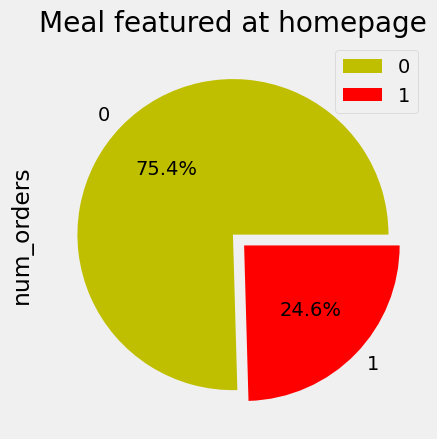

In [46]:
df.groupby('homepage_featured').num_orders.agg(sum).reset_index()\
.plot(kind = 'pie', y='num_orders',explode = [0,0.1],autopct="%0.1f%%", colors = ['y','r'],title='Meal featured at homepage');
print('1 = Featured \n0 = Not Featured')

### Treating Missing and Duplicate Data

In [52]:
df.isnull().sum()

week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
category                 0
cuisine                  0
city_code                0
region_code              0
center_type              0
op_area                  0
dtype: int64

In [53]:
df.duplicated().sum()

0

In [58]:
df['center_type']=df['center_type'].replace({'TYPE_A':1,'TYPE_B':2,'TYPE_C':3 })

In [59]:
df

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,3,2.0
1,1,55,1993,136.83,135.83,0,0,270,Beverages,Thai,647,56,3,2.0
2,1,55,2539,134.86,135.86,0,0,189,Beverages,Thai,647,56,3,2.0
3,1,55,2139,339.50,437.53,0,0,54,Beverages,Indian,647,56,3,2.0
4,1,55,2631,243.50,242.50,0,0,40,Beverages,Indian,647,56,3,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489116,155,61,1543,482.09,484.09,0,0,110,Desert,Indian,473,77,1,4.5
489117,155,61,2304,483.09,483.09,0,0,114,Desert,Indian,473,77,1,4.5
489118,155,61,2664,322.07,323.07,0,0,228,Salad,Italian,473,77,1,4.5
489119,155,61,2569,322.07,323.07,0,0,228,Salad,Italian,473,77,1,4.5


## Modeling - Test and Train the Model 

In [60]:
X = df.drop(columns=['num_orders', 'week'])
y = df['num_orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=21)

print("X_train dataset: ", X_train.shape)
print("y_train dataset: ", y_train.shape)
print("X_test dataset: ", X_test.shape)
print("y_test dataset: ", y_test.shape)

X_train dataset:  (391296, 12)
y_train dataset:  (391296,)
X_test dataset:  (97825, 12)
y_test dataset:  (97825,)


In [61]:
X_train

,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,category,cuisine,city_code,region_code,center_type,op_area
466764,93,1207,340.53,338.53,0,0,Beverages,Continental,461,34,1,3.9
362169,108,2490,185.33,290.03,1,1,Salad,Italian,579,56,2,4.4
40605,74,2867,658.63,659.63,0,0,Seafood,Continental,702,35,1,2.8
417989,99,2640,319.13,320.13,0,0,Starters,Thai,596,71,1,4.5
290003,52,1230,316.28,387.09,0,0,Beverages,Continental,685,56,2,5.6
...,...,...,...,...,...,...,...,...,...,...,...,...
81968,108,2664,320.13,319.13,0,0,Salad,Italian,579,56,2,4.4
140036,74,2290,259.99,309.43,0,0,Rice Bowl,Indian,702,35,1,2.8
202552,52,1216,407.43,408.43,0,0,Pasta,Italian,685,56,2,5.6
333007,34,1216,339.50,405.52,0,0,Pasta,Italian,615,34,2,4.2


In [62]:
num_features = X_train.select_dtypes(exclude=['object']).columns.values.tolist()
cat_features = X_train.select_dtypes(exclude=['float64', 'int64']).columns.values.tolist()

print(num_features)
print(cat_features)

['center_id', 'meal_id', 'checkout_price', 'base_price', 'emailer_for_promotion', 'homepage_featured', 'city_code', 'region_code', 'center_type', 'op_area']
['category', 'cuisine']


In [146]:
preprocessor = make_column_transformer((OneHotEncoder(), ['category', 'cuisine']),
                                       remainder='passthrough')
processed_train=preprocessor.fit_transform(X_train)
processed_test=preprocessor.transform(X_test)

In [68]:
X_train_final=pd.DataFrame(processed_train, columns=preprocessor.get_feature_names())
X_train_final

,onehotencoder__x0_Beverages,onehotencoder__x0_Biryani,onehotencoder__x0_Desert,onehotencoder__x0_Extras,onehotencoder__x0_Fish,onehotencoder__x0_Other Snacks,onehotencoder__x0_Pasta,onehotencoder__x0_Pizza,onehotencoder__x0_Rice Bowl,onehotencoder__x0_Salad,onehotencoder__x0_Sandwich,onehotencoder__x0_Seafood,onehotencoder__x0_Soup,onehotencoder__x0_Starters,onehotencoder__x1_Continental,onehotencoder__x1_Indian,onehotencoder__x1_Italian,onehotencoder__x1_Thai,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,region_code,center_type,op_area
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,93.0,1207.0,340.53,338.53,0.0,0.0,461.0,34.0,1.0,3.9
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,108.0,2490.0,185.33,290.03,1.0,1.0,579.0,56.0,2.0,4.4
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,74.0,2867.0,658.63,659.63,0.0,0.0,702.0,35.0,1.0,2.8
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,99.0,2640.0,319.13,320.13,0.0,0.0,596.0,71.0,1.0,4.5
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,52.0,1230.0,316.28,387.09,0.0,0.0,685.0,56.0,2.0,5.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391291,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,108.0,2664.0,320.13,319.13,0.0,0.0,579.0,56.0,2.0,4.4
391292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,74.0,2290.0,259.99,309.43,0.0,0.0,702.0,35.0,1.0,2.8
391293,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,52.0,1216.0,407.43,408.43,0.0,0.0,685.0,56.0,2.0,5.6
391294,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,34.0,1216.0,339.50,405.52,0.0,0.0,615.0,34.0,2.0,4.2


In [71]:
processed_test=preprocessor.transform(X_test)
X_test_final=pd.DataFrame(processed_test,columns=preprocessor.get_feature_names())

In [94]:
y_train=pd.DataFrame(y_train)
y_train_final=y_train.reset_index().drop(['index'],axis=1)
y_test=pd.DataFrame(y_test)
y_test_final=y_test.reset_index().drop(['index'],axis=1)

## Results Investigation

#### Basic Linear Regression

In [107]:
# Basic Linear Regression model to determine the train and test score 
start_LR = time.time()
LR_model = LinearRegression().fit(X_train_final, y_train_final)
end_LR = time.time()
time_LR=end_LR - start_LR
LR_train_score=LR_model.score(X_train_final, y_train_final)
LR_test_score=LR_model.score(X_test_final, y_test_final)
print('Train Score :',LR_train_score)
print('Test Score :',LR_test_score)
print('Time to fit and train the model :',time_LR)

Train Score : 0.4071316484280251
Test Score : 0.3903955537313294
Time to fit and train the model : 0.4375731945037842


In [108]:
# Basic Linear Regression model train and test mean squared error results
y_pred_train = LR_model.predict(X_train_final)
train_mse = mean_squared_error(y_train_final, y_pred_train)
y_pred_test = LR_model.predict(X_test_final)
test_mse = mean_squared_error(y_test_final, y_pred_test)
print('Train mean squared error :',train_mse)
print('Train mean squared error :',test_mse)

Train mean squared error : 86610.34097502357
Train mean squared error : 95346.45945270604


#### Basic DecisionTree Regression

In [112]:
# Basic DecisionTree Regression model to determine the train and test score 
start_DTs = time.time()
DT_model = DecisionTreeRegressor().fit(X_train_final, y_train_final)
end_DTs = time.time()
time_DTs=end_DTs - start_DTs
DTs_train_score=DT_model.score(X_train_final, y_train_final)
DTs_test_score=DT_model.score(X_test_final, y_test_final)
print('Train Score :',DTs_train_score)
print('Test Score :',DTs_test_score)
print('Time to fit and train the model :',time_DTs)

Train Score : 0.982497068282876
Test Score : 0.6829759552722111
Time to fit and train the model : 5.57056999206543


In [113]:
# Basic DecisionTree Regression model train and test mean squared error results
y_pred_train = DT_model.predict(X_train_final)
train_mse = mean_squared_error(y_train_final, y_pred_train)
y_pred_test = DT_model.predict(X_test_final)
test_mse = mean_squared_error(y_test_final, y_pred_test)
print('Train mean squared error :',train_mse)
print('Train mean squared error :',test_mse)

Train mean squared error : 2556.9502572758392
Train mean squared error : 49584.80931559512


#### Basic XGBBoost Regression 

In [118]:
# Basic XGBBoost Regression model to determine the train and test score 
start_XGB = time.time()
XGB_model = XGBRegressor().fit(X_train_final, y_train_final)
end_XGB = time.time()
time_XGB=end_XGB - start_XGB
XGB_train_score=XGB_model.score(X_train_final, y_train_final)
XGB_test_score=XGB_model.score(X_test_final, y_test_final)
print('Train Score :',XGB_train_score)
print('Test Score :',XGB_test_score)
print('Time to fit and train the model :',time_XGB)

Train Score : 0.8338262051551069
Test Score : 0.796293526261811
Time to fit and train the model : 17.59853768348694


In [119]:
# Basic XGBBoost Regression model train and test mean squared error results
y_pred_train = XGB_model.predict(X_train_final)
train_mse = mean_squared_error(y_train_final, y_pred_train)
y_pred_test = XGB_model.predict(X_test_final)
test_mse = mean_squared_error(y_test_final, y_pred_test)
print('Train mean squared error :',train_mse)
print('Train mean squared error :',test_mse)

Train mean squared error : 24275.826150053075
Train mean squared error : 31861.137426763136
